# 4: Time-Series MSOT Data Analysis

Time-Series photoacoustic image analysis is implemented for two common imaging methods in PATATO. Oxygen-Enhanced imaging data and Dynamic Contrast Enhanced imaging data can be processed. Full details of the methods involved can be seen here: [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5562224/](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5562224/). To briefly summarise, mice with subcutaneous tumours were imaged with MSOT and two separate scans were taken:

* Oxygen-enhanced (OE) scan: A single slice was imaged continuously. To start with, **the breathing gas was 100% air and then changed to 100% oxygen after 5 minutes.**
* Dynamic contrast-enhanced (DCE) scan: A single slice was imaged continuously. After five minutes of baseline imaging, a bolus of indocyanine green (ICG), a contrast agent, was injected intravenously. 

**Image reconstruction (backprojection) and linear spectral unmixing was applied.** For the OE scan, spectral unmixing was applied to estimate the relative concentration of deoxyhaemoglobin and oxyhaemoglobin. For the DCE scan, spectral unmixing was applied to estimate the relative concentration of deoxyhaemoglobin, oxyhaemoglobin and ICG.

In [1]:
import patato as pat
import matplotlib.pyplot as plt
import numpy as np

Firstly, we load the example data provided with patato. The pre-calculated reconstructed images are extracted, along with the pre-drawn ROIs.  Example data can be found in our example data repository [here](https://doi.org/10.17863/CAM.93181).

In [2]:
# Change this to be a OE dataset instead of a DCE dataset.
pa_so2 = pat.PAData.from_hdf5("../intro/dataset/invivo_oe.hdf5")
pa_dce = pat.PAData.from_hdf5("../intro/dataset/invivo_dce.hdf5") # We'll get the ROIs from here.
pa_so2.set_default_recon(("Reference Backprojection", "0"))
pa_dce.set_default_recon(("Reference Backprojection", "0"))
pa_dce.default_unmixing_type = "ICG"
pa_dce.external_roi_interface = pa_so2

# Get the oe reconstructions, so2 and delta icgs:
rec = pa_so2.get_scan_reconstructions()
so2 = pa_so2.get_scan_so2()
icg = pa_dce.get_scan_unmixed()[:, 2:] # ICG is the 3rd dataset in the unmixed data.

times = pa_so2.get_timestamps()[:, 0]
times -= times[0]
times /= 60

icg_times = pa_dce.get_timestamps()[:, 0]
icg_times -= icg_times[0]
icg_times /= 60

roi_tumour_right = pa_so2.get_rois()["tumour_right", "0"]
roi_tumour_left = pa_so2.get_rois()["tumour_left", "0"]
roi_reference = pa_so2.get_rois()["reference_", "0"]

Firstly, we show an example of the photoacoustic $sO_2^{MSOT}$ estimate when breathing air and when breathing oxygen. A clear increase in the tumour oxygenation is observed on oxygen vs. on air.

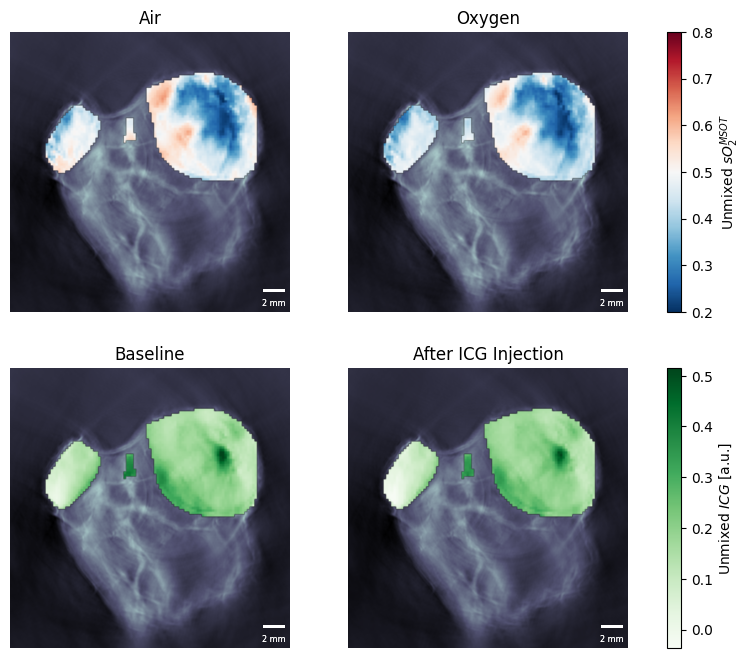

In [3]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

# Show initial slice
rec[0].imshow(ax=ax1)
im = so2[0].imshow(roi_mask=[roi_tumour_right, roi_tumour_left, roi_reference], clim=(0.2,0.8), ax=ax1)
ax1.set_title("Air")

# Show final slice
rec[-1].imshow(ax=ax2)
im = so2[-1].imshow(roi_mask=[roi_tumour_right, roi_tumour_left, roi_reference], clim=(0.2,0.8), ax=ax2)
ax2.set_title("Oxygen")

plt.colorbar(im, ax=[ax1, ax2], label="Unmixed $sO_2^{MSOT}$")

# Show initial slice
rec[0].imshow(ax=ax3)
im1 = icg[0].imshow(roi_mask=[roi_tumour_right, roi_tumour_left, roi_reference], ax=ax3, cmap="Greens")
ax3.set_title("Baseline")

# Show final slice
rec[30].imshow(ax=ax4)
im2 = icg[75].imshow(roi_mask=[roi_tumour_right, roi_tumour_left, roi_reference], ax=ax4, cmap="Greens")
im1.set_clim(im2.get_clim())
ax4.set_title("After ICG Injection")
plt.colorbar(im2, ax=[ax3, ax4], label="Unmixed $ICG$ [a.u.]")

plt.show()

We can also plot a trace of the blood oxygenation or ICG concentration over time in the three different regions.

In [4]:
def get_trace(time_series_data, region, filter_bad=False):
    mask, _ = region.to_mask_slice(time_series_data)
    timeseries = time_series_data.raw_data.T[mask.T].T[:, 0, :]
    # Unmixed SO2 can be out of the interval [0, 1] when there is low SNR.
    if filter_bad:
        timeseries[(timeseries>1) | (timeseries<0)] = np.nan
    return np.nanmean(timeseries, axis=-1)

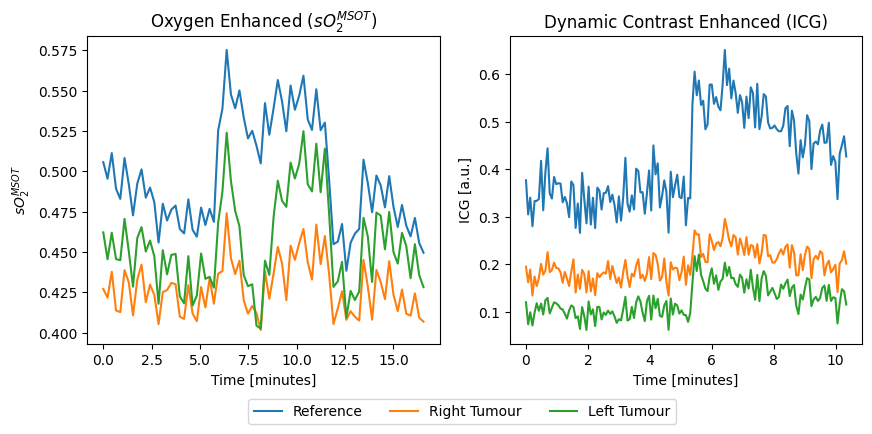

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax2.plot(icg_times, get_trace(icg, roi_reference), label="Reference")
ax2.plot(icg_times, get_trace(icg, roi_tumour_right), label="Right Tumour")
ax2.plot(icg_times, get_trace(icg, roi_tumour_left), label="Left Tumour")
ax2.set_xlabel("Time [minutes]")
ax2.set_ylabel("ICG [a.u.]")
ax2.set_title("Dynamic Contrast Enhanced (ICG)")

ax1.plot(times, get_trace(so2, roi_reference, True), label="Reference")
ax1.plot(times, get_trace(so2, roi_tumour_right, True), label="Right Tumour")
ax1.plot(times, get_trace(so2, roi_tumour_left, True), label="Left Tumour")
ax1.set_xlabel("Time [minutes]")
ax1.set_ylabel("$sO_2^{MSOT}$")
ax1.set_title("Oxygen Enhanced ($sO_2^{MSOT}$)")
fig.legend(*ax1.get_legend_handles_labels(), loc="upper center", ncols=3, bbox_to_anchor=(0.5, -0.01))
plt.show()

The built in `GasChallengeAnalyser` and `DCEAnalyser` are then applied to extract the change in the ICG content and $sO_2^{MSOT}$ from baseline to peak.

In [6]:
gca = pat.GasChallengeAnalyser(display_output=False)
dso2, _, (baseline_so2, baseline_sigma_so2) = gca.run(so2, pa_so2)

dce = pat.DCEAnalyser(display_output=False)
dicg, _, [baseline_icg, baseline_sigma_icg] = dce.run(pa_dce.get_scan_unmixed(), pa_dce)

<>:12: SyntaxWarning: invalid escape sequence '\D'
<>:12: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_1237442/1911861395.py:12: SyntaxWarning: invalid escape sequence '\D'
  ax2.set_title("$\Delta ICG$")


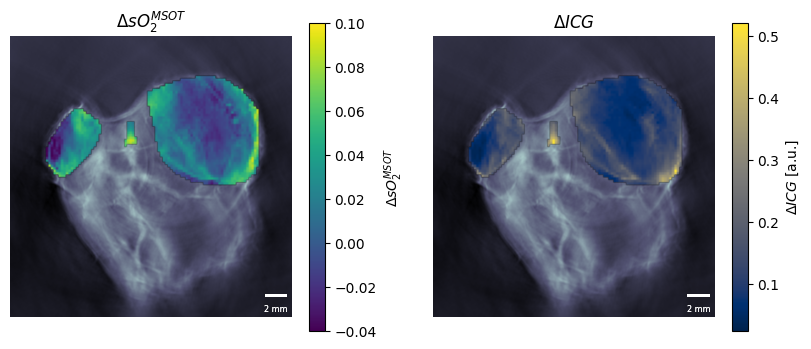

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Draw delta sO2
rec[0].imshow(ax=ax1)
im = dso2.imshow(roi_mask=[roi_tumour_right, roi_tumour_left, roi_reference], ax=ax1, clim=(-0.04,0.1))
ax1.set_title(r"$\Delta sO_2^{MSOT}$")
plt.colorbar(im, ax=ax1, label=r"$\Delta sO_2^{MSOT}$")

# Draw delta ICG
rec[0].imshow(ax=ax2)
im = dicg.imshow(roi_mask=[roi_tumour_right,roi_tumour_left,roi_reference], ax=ax2)
ax2.set_title("$\Delta ICG$")
plt.colorbar(im, ax=ax2, label=r"$\Delta ICG$ [a.u.]")
plt.show()

By plotting $\Delta sO_2^{MSOT}$ against $\Delta ICG$, we can see that the oxygen enhanced experiment is a good metric of perfusion.

In [8]:
def get_pixel_values(delta_values, region, filter_bad=False):
    mask, _ = region.to_mask_slice(delta_values)
    delta = delta_values.raw_data.T[mask.T].T
    
    if filter_bad:
        delta[(delta>0.1) | (delta<-0.1)] = np.nan
    return delta

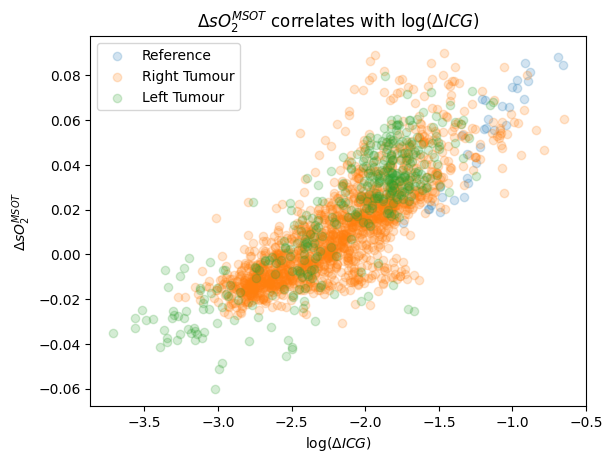

In [9]:
from scipy.stats import pearsonr

plt.scatter(np.log(get_pixel_values(dicg, roi_reference)), get_pixel_values(dso2, roi_reference, True), alpha=0.2, label="Reference")
plt.scatter(np.log(get_pixel_values(dicg, roi_tumour_right)), get_pixel_values(dso2, roi_tumour_right, True), alpha=0.2, label="Right Tumour")
plt.scatter(np.log(get_pixel_values(dicg, roi_tumour_left)), get_pixel_values(dso2, roi_tumour_left, True), alpha=0.2, label="Left Tumour")
plt.xlabel(r"$\log(\Delta ICG)$")
plt.ylabel(r"$\Delta sO_2^{MSOT}$")
plt.title(r"$\Delta sO_2^{MSOT}$ correlates with $\log (\Delta ICG$)")
plt.legend()
plt.show()

In [ ]:
summary_measurements = pa_so2.summary_measurements(metrics=["so2", "dso2", "thb", "icg"])
# This is a pandas data frame containing measurements averaged over regions of interest.

display(summary_measurements)

No icg channel found
Skipping metric dso2
Skipping metric dso2
Skipping metric dso2


,Timings,Area,z,run,repetition,class,position,generated,number,name,Wavelengths,so2_mean,thb_mean,so2_median,thb_median,so2_std,thb_std
0,"[[63737152356.08234, 63737152356.66137, 637371...",279,59.65,1,1,reference,,False,0,"(reference_, 0)","[700.0, 730.0, 750.0, 760.0, 770.0, 800.0, 820...","[0.50571936, 0.49540773, 0.5113369, 0.48919734...","[504.37576, 495.02005, 497.32736, 505.81186, 5...","[0.5055081, 0.49585068, 0.5124908, 0.49105445,...","[503.83728, 495.38806, 496.52316, 506.0904, 50...","[0.029004583, 0.029012078, 0.02821873, 0.02769...","[68.55161, 67.66886, 67.89518, 68.927704, 68.1..."
1,"[[63737152356.08234, 63737152356.66137, 637371...",3441,59.65,1,1,tumour,left,False,0,"(tumour_left, 0)","[700.0, 730.0, 750.0, 760.0, 770.0, 800.0, 820...","[0.46213683, 0.44547024, 0.46193668, 0.4456143...","[190.11526, 185.54024, 186.8268, 190.59695, 18...","[0.47547063, 0.4601129, 0.47577664, 0.4587043,...","[199.56006, 195.2909, 196.9133, 201.16101, 199...","[0.05465061, 0.05791767, 0.052769884, 0.054321...","[64.70382, 63.669518, 63.65155, 65.075745, 64...."
2,"[[63737152356.08234, 63737152356.66137, 637371...",14084,59.65,1,1,tumour,right,False,0,"(tumour_right, 0)","[700.0, 730.0, 750.0, 760.0, 770.0, 800.0, 820...","[0.42706907, 0.42173597, 0.43769035, 0.4137012...","[244.13866, 240.47891, 240.99994, 244.89986, 2...","[0.4446971, 0.43991864, 0.45411336, 0.42948672...","[230.10826, 226.38632, 227.56372, 231.11935, 2...","[0.10115903, 0.10076951, 0.09838934, 0.0991062...","[65.62729, 64.46939, 64.25793, 65.742615, 65.4..."
